In [6]:
from dotenv import load_dotenv
import fmpsdk
import pandas as pd
import os

load_dotenv()
apikey = os.environ.get("apikey")
snp500 = pd.DataFrame(fmpsdk.sp500_constituent(apikey))

from fetch import PropertyNameList, PropertyFetcher

property_fetcher = PropertyFetcher()
key_list = [PropertyNameList.PER, PropertyNameList.PBR, PropertyNameList.PCR, PropertyNameList.DIVIDEND_YIELD,
            PropertyNameList.DEBT_RATIO]

property_fetcher.register(key_list=key_list, csv_file_directory='data/financial-ratios-quarter-20220820.csv')
property_fetcher.register(key_list=PropertyNameList.PROFILE, csv_file_directory='data/company-profile-20220827.csv')
property_fetcher.register(key_list=[PropertyNameList.MARKET_CAPITALIZATION],
                          csv_file_directory='data/market-capitalization-20220828.csv')

from analyze import Analyst, TableNameList

analyst = Analyst(fetcher=property_fetcher)
analyst.register(table_name=TableNameList.STOCK_PRICE,
                 csv_file_directory='data/snp500_price_list_19620102_20220814.csv')
analyst.register(table_name=TableNameList.ECONOMIC_INDICATOR,
                 csv_file_directory='data/economic-indicators-20220828.csv')
analyst.register(table_name=TableNameList.MARKET_INDEX, csv_file_directory='data/market-index-20220826.csv')
analyst.register(table_name=TableNameList.ETC, csv_file_directory='data/etc-history-20220828.csv')


In [2]:
from strategy import *

is_absolute = True
relative_value_range_list = [(0.0, 1.0), (0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0)]

filter_list = []
target_key = PropertyNameList.PCR
for relative_value_range in relative_value_range_list:
    filter_name = target_key + '=(' + str(relative_value_range[0]) + '-' + str(relative_value_range[1]) + ')'
    relative_seletor = Selector(type=SelectorType.HORIZON_RANGE, key=target_key, value=relative_value_range, horizon=2,
                                is_absolute=False)
    selector_sequence = SelectorSequence(selectors=[relative_seletor])
    filter_list.append(Filter(selector_sequence_union=[selector_sequence], name=filter_name))

In [3]:
from strategy import *

filter_list = []

sector_selector = Selector(type=SelectorType.PROFILE, key=PropertyNameList.SECTOR,
                           value=[SelectorValue.PROFILE_SECTOR_INFORMATION_TECHNOLOGY])
sector_pbr = Selector(type=SelectorType.HORIZON_RANGE, key=PropertyNameList.PBR,
                      value=(0.8, 1.0), horizon=3, is_absolute=False)
selector_sequence = SelectorSequence(selectors=[sector_selector, sector_pbr])
filter_tech = Filter(selector_sequence_union=[selector_sequence], name="tech")

sector_selector = Selector(type=SelectorType.PROFILE, key=PropertyNameList.SECTOR,
                           value=[SelectorValue.PROFILE_SECTOR_FINANCIALS])
selector_sequence = SelectorSequence(selectors=[sector_selector])
filter_fin = Filter(selector_sequence_union=[selector_sequence], name="fin")

filter_list = [filter_fin, filter_tech]


In [4]:
initial_holdings = [Asset(symbol=symbol) for symbol in snp500['symbol']]
start_date = datetime.date(2010, 8, 30)
end_date = datetime.date(2022, 8, 30)
rebalance_dates = pd.date_range(start_date, end_date, freq='1Y', inclusive='both')

strategist_list = []
for filter_ in filter_list:
    strategist_name = filter_.name
    strategist = Strategist(fetcher=property_fetcher, name=strategist_name, asset_pool=initial_holdings,
                            start_date=start_date, end_date=end_date)
    for rebalance_date in rebalance_dates:
        strategist.select_assets(filter=filter_, rebalance_date=rebalance_date.date())
    strategist_list.append(strategist)

analyst.reset()
for strategist in strategist_list:
    analyst.write_report(strategist)

analyst.update_assets_property(PropertyNameList.PER)
analyst.update_assets_property(PropertyNameList.DIVIDEND_YIELD)


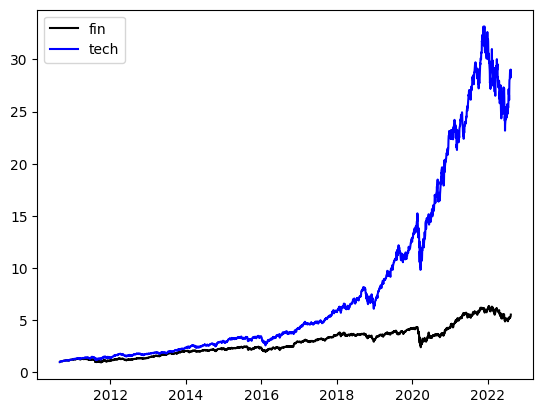

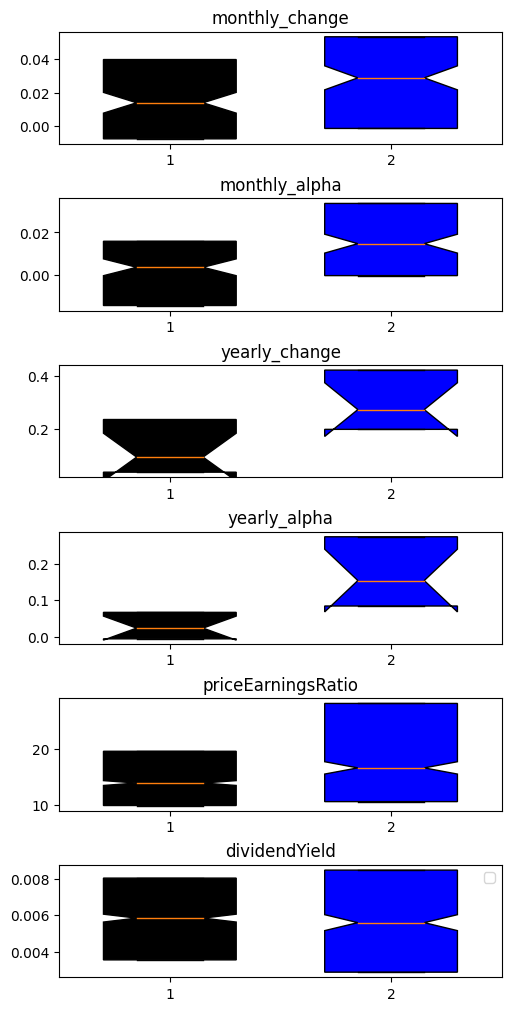

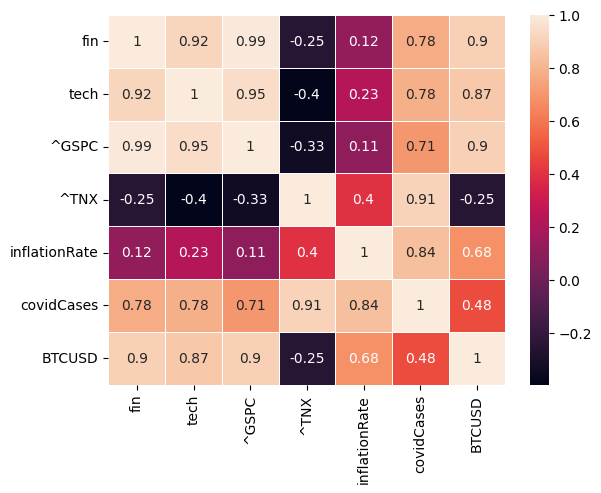

In [5]:
% matplotlib inline

import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 100  # default for me was 75

plt.figure(1)
analyst.draw_price_history()
plt.legend()

analyst.draw_property_distributions()
plt.legend()

from analyze import MarketIndexList, EconomicIndicatorList, EtcList
from datetime import date

target_history_list_dict = {TableNameList.MARKET_INDEX: [MarketIndexList.SNP500, MarketIndexList.TREASURY_10YEAR],
                            TableNameList.ECONOMIC_INDICATOR: [EconomicIndicatorList.INFLATION_RATE],
                            TableNameList.ETC: [EtcList.COVID, EtcList.BITCOIN]}

plt.figure(4)
analyst.draw_correlation_heatmap(target_history_list_dict, start_date, end_date)
